In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor,BaggingRegressor
import joblib


df = pd.read_csv("dataset.csv",delimiter=",")
print(f'Null Values: {df.isnull().sum()}')
print(f'Duplicated Values: {df.duplicated().sum()}')
print(f'Unique Values: {df.nunique().sum()}')
print(f'dtypes: {df.dtypes}')
df.drop_duplicates(inplace=True)
print(df.head(10))

Null Values: price          0
year           0
age            0
beds           0
baths          0
home_size      0
parcel_size    0
pool           0
dist_cbd       0
dist_lakes     0
x_coord        0
y_coord        0
dtype: int64
Duplicated Values: 3
Unique Values: 55741
dtypes: price            int64
year             int64
age              int64
beds             int64
baths          float64
home_size        int64
parcel_size      int64
pool             int64
dist_cbd       float64
dist_lakes     float64
x_coord        float64
y_coord          int64
dtype: object
    price  year  age  beds  baths  home_size  parcel_size  pool  dist_cbd  \
0  250412  2001    0     5    3.0       3217        11521     1  12351.12   
1  195068  2000    4     4    3.0       2770         6199     1  18574.37   
2  232224  2002    7     4    2.5       2191        11130     1  17519.73   
3   90481  2003   33     3    1.0       1025         8881     0   9970.23   
4  297092  2000    0     4    3.0       2790 

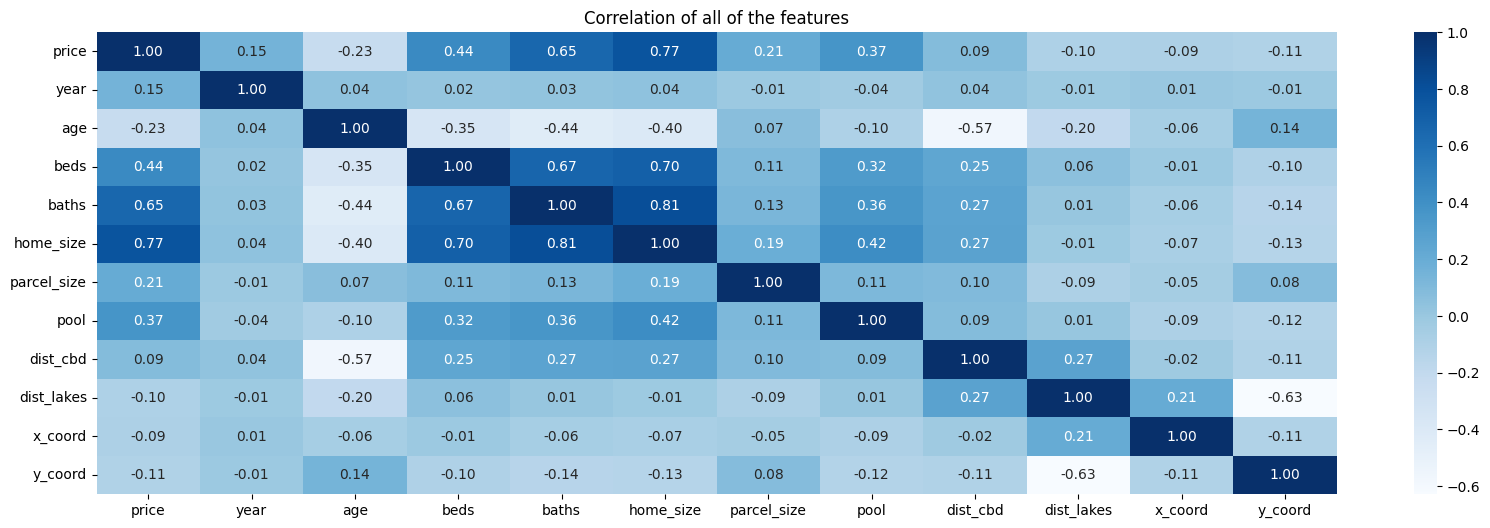

In [2]:
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(),fmt=".2f",annot=True,cmap="Blues")
plt.title("Correlation of all of the features")
plt.savefig("images/heatmap.png")
plt.show()

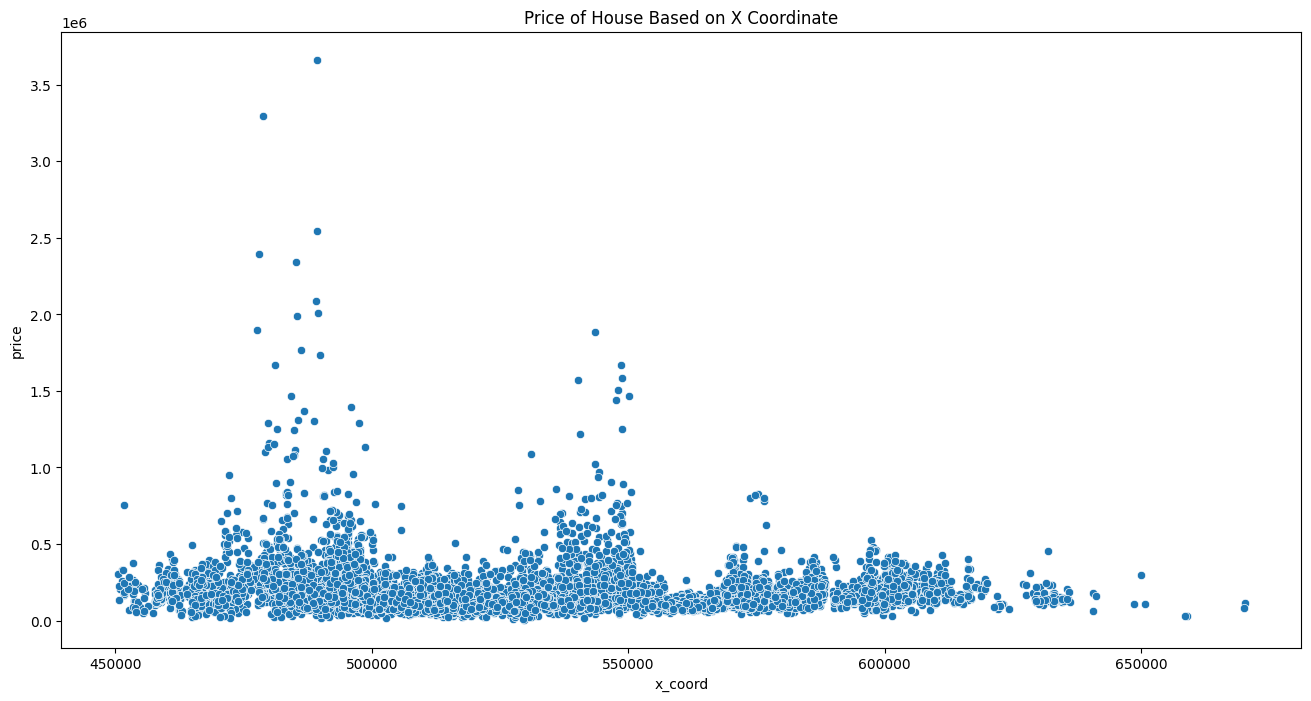

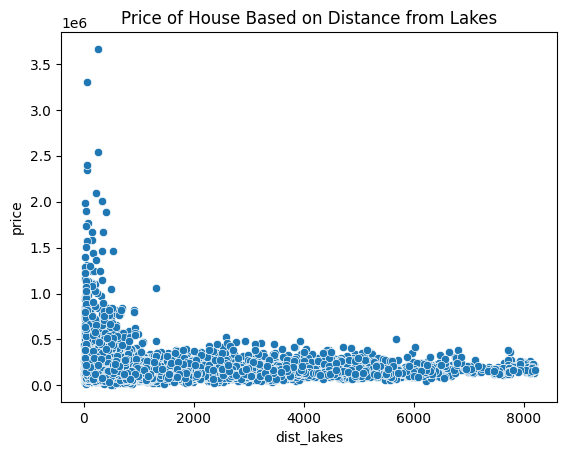

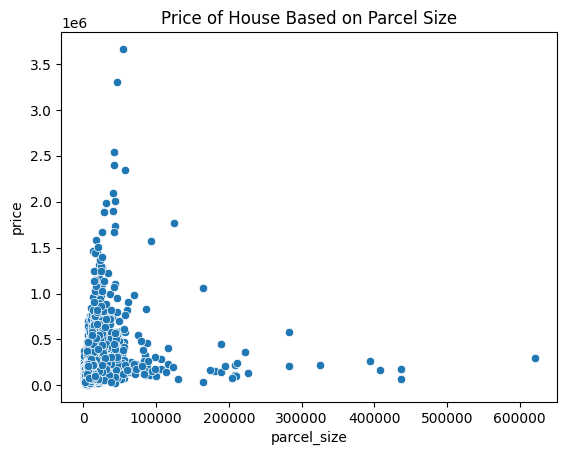

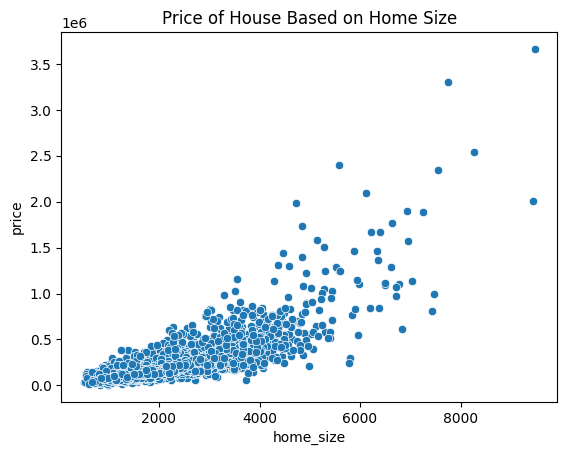

In [3]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=df,x='x_coord',y='price')
plt.title("Price of House Based on X Coordinate")
plt.savefig("images/Houseprice_xcoord.png")
plt.show()
 
sns.scatterplot(data=df,x='dist_lakes',y='price')
plt.title('Price of House Based on Distance from Lakes')
plt.savefig("images/distance from lakes house_price.png")
plt.show()

sns.scatterplot(data=df,x='parcel_size',y='price')
plt.title("Price of House Based on Parcel Size")
plt.savefig("images/parcel_size_house_price.png")
plt.show()

sns.scatterplot(data=df,x='home_size',y='price')
plt.title("Price of House Based on Home Size")
plt.savefig("images/home size_price.png")
plt.show()

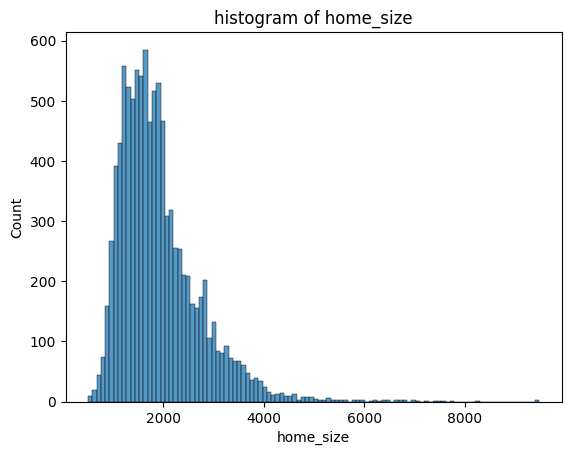

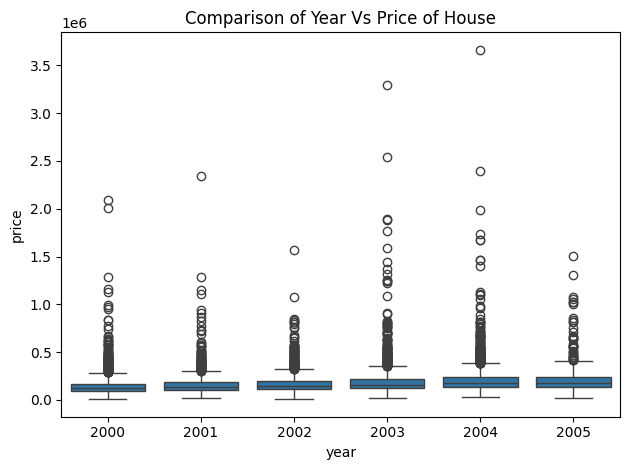

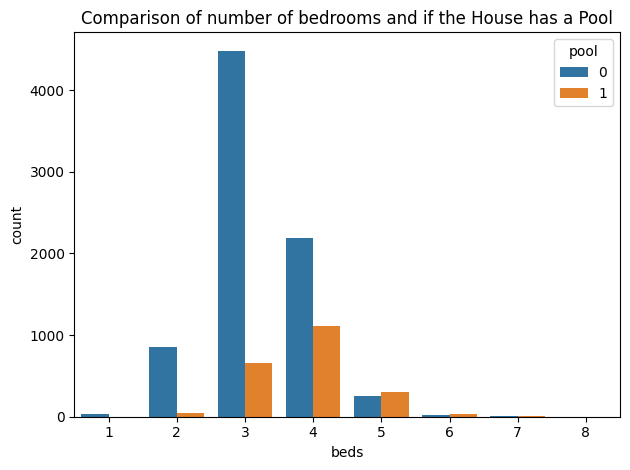

In [4]:
sns.histplot(data=df,x='home_size')
plt.title("histogram of home_size")
plt.savefig("images/Hist_housesize.png")
plt.show()


sns.boxplot(data=df,x='year',y='price')
plt.title("Comparison of Year Vs Price of House")
plt.savefig("images/year_price.png")
plt.tight_layout()
plt.show()

 
sns.countplot(data=df,x='beds',hue='pool')
plt.title("Comparison of number of bedrooms and if the House has a Pool")
plt.savefig("images/bedrooms_pool.png")
plt.tight_layout()
plt.show()

In [5]:
X = df.drop('price',axis=1)
y = df['price']

olsmodel = sm.OLS(exog=sm.add_constant(X),endog=y).fit()
print(f'anova: {olsmodel.summary()}')

anova:                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     1819.
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:21:45   Log-Likelihood:            -1.2737e+05
No. Observations:                9997   AIC:                         2.548e+05
Df Residuals:                    9985   BIC:                         2.548e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.314e+07   1.09e+06    -21.21

                       Model        R2           MSE  Cross-val Scores
0           LinearRegression  0.669861  4.928000e+09     -7.373574e+09
1                      lasso  0.669862  4.927979e+09     -7.373564e+09
2                      ridge  0.669889  4.927576e+09     -7.373586e+09
3  GradientBoostingRegressor  0.805822  2.898507e+09     -4.410145e+09
4           BaggingRegressor  0.780282  3.279739e+09     -4.765212e+09


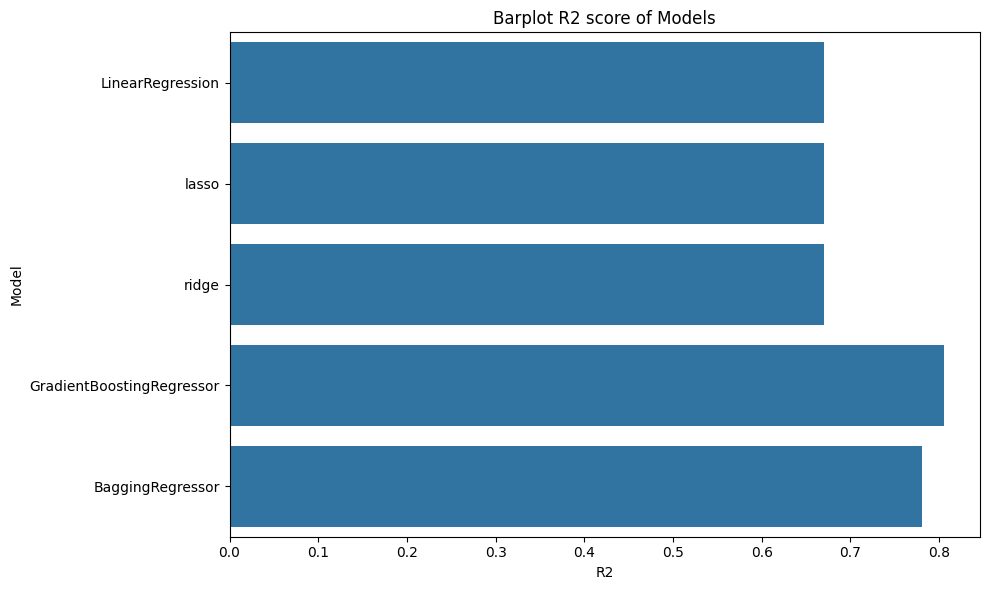

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def evaluate(y_test,pred,model_name,r2,mse,cv_scores):


    result = {
        "Model": model_name,
        "R2": r2,
        "MSE": mse,
        "Cross-val Scores":cv_scores.mean()
    }

    return result


model_dict = []
models = {
    "LinearRegression":LinearRegression(),
    "lasso":Lasso(),
    "ridge":Ridge(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "BaggingRegressor":BaggingRegressor()
}



for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=10,scoring="neg_mean_squared_error")
    model_results = evaluate(y_test, pred, model_name,r2,mse,cv_scores)
    model_dict.append(model_results)


df_results = pd.DataFrame(model_dict)
print(df_results.head())


plt.figure(figsize=(10,6))
sns.barplot(x=df_results["R2"],y=df_results["Model"])
plt.title("Barplot R2 score of Models")
plt.tight_layout()
plt.savefig("images/r2_scores.png")
plt.show()









In [7]:
linearregression_params = {
'copy_X': [True,False], 
'fit_intercept': [True,False], 
'n_jobs': [1000,5000,10000], 
'positive': [True,False]}



lasso_params = {
    'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }


ridge_params = {
    'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }



gradientboosting_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10]
    }

bagginregression_params = {
    'n_estimators': [50,100,200],
    'max_samples' : [1.0,0.8,0.6],
    'max_features': [1.0,0.8,0.6]
}



models = {
    "LinearRegression":(LinearRegression(),linearregression_params),
    "Lasso":(Lasso(),lasso_params),
    "ridge":(Ridge(),ridge_params),
    "GradientBoostingRegresser":(GradientBoostingRegressor(),gradientboosting_params),
    "BaggingREgressor":(BaggingRegressor(),bagginregression_params),
    }

best_scores = []

for model_name,(model,params) in models.items():
    grid_search = GridSearchCV(model,params,scoring="neg_mean_squared_error",cv=4,n_jobs=-1)
    grid_search.fit(X_train_scaled,y_train)
    print(f'Best Params for {model_name}: {grid_search.best_params_}')
    print(f'Best Score for {model_name}: {grid_search.best_score_}')
    best_scores.append({"Model":model_name,"Neg-Mean-Average-MSE":grid_search.best_score_})
    

best_scores_df = pd.DataFrame(best_scores)
print(best_scores_df.head())

Best Params for LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1000, 'positive': False}
Best Score for LinearRegression: -7406106356.494888
Best Params for Lasso: {'alpha': 100}
Best Score for Lasso: -7405685930.618313
Best Params for ridge: {'alpha': 1e-15}
Best Score for ridge: -7406106356.4948845
Best Params for GradientBoostingRegresser: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score for GradientBoostingRegresser: -3523631049.951008
Best Params for BaggingREgressor: {'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 100}
Best Score for BaggingREgressor: -3923786505.6171093
                       Model  Neg-Mean-Average-MSE
0           LinearRegression         -7.406106e+09
1                      Lasso         -7.405686e+09
2                      ridge         -7.406106e+09
3  GradientBoostingRegresser         -3.523631e+09
4           BaggingREgressor         -3.923787e+09


In [9]:
from sklearn.pipeline import Pipeline
model = GradientBoostingRegressor(n_estimators=200,min_samples_split=10,max_depth=5,learning_rate=0.2)


pipe = Pipeline(steps=[("scaler",StandardScaler()),("model",model)])
pipe.fit(X_train,y_train)
pred = pipe.predict(X_test)
print(r2_score(y_test,pred))

0.8341448999604903


In [10]:
joblib.dump(pipe,"models/model.joblib")

['models/model.joblib']